# **AN2DL Challenge 2 - Image Classification**


In [1]:
# Enviroment
isColab = False
isKaggle = False
isWsl = False

# Set seed for reproducibility
SEED = 42

## **Loading Enviroment**


In [2]:
import os

# Directory di default
current_dir = os.getcwd()   

if isColab:
    from google.colab import drive
    
    drive.mount("/gdrive")
    current_dir = "/gdrive/My\\ Drive/Colab\\ Notebooks/[2025-2026]\\ AN2DL/AN2DL-challenge-2"
    print("In esecuzione su Colab. Google Drive montato.")
    %cd $current_dir
elif isKaggle:
    kaggle_work_dir = "/kaggle/working/AN2DL-challenge-2"
    os.makedirs(kaggle_work_dir, exist_ok=True)
    current_dir = kaggle_work_dir
    print("In esecuzione su Kaggle. Directory di lavoro impostata.")
    os.chdir(current_dir)
elif isWsl:
    local_pref = r"/mnt/g/Il mio Drive/Colab Notebooks/[2025-2026] AN2DL/AN2DL-challenge-2"
    current_dir = local_pref if os.path.isdir(local_pref) else os.getcwd()
    print(f"Esecuzione su WSL. Directory corrente impostata a: {current_dir}")
    os.chdir(current_dir)
else:
    print("Esecuzione locale. Salto mount Google Drive.")
    local_pref = r"G:\Il mio Drive\Colab Notebooks\[2025-2026] AN2DL\AN2DL-challenge-2"
    current_dir = local_pref if os.path.isdir(local_pref) else os.getcwd()
    print(f"Directory corrente impostata a: {current_dir}")
    os.chdir(current_dir)

print(f"Changed directory to: {current_dir}")

Esecuzione locale. Salto mount Google Drive.
Directory corrente impostata a: G:\Il mio Drive\Colab Notebooks\[2025-2026] AN2DL\AN2DL-challenge-2
Changed directory to: G:\Il mio Drive\Colab Notebooks\[2025-2026] AN2DL\AN2DL-challenge-2


## **Import Libraries**


In [3]:
# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision.transforms import v2 as transforms
from torch.utils.data import TensorDataset, DataLoader
%pip install torchview
from torchview import draw_graph

# Configurazione di TensorBoard e directory
logs_dir = "tensorboard"
if isColab or isKaggle:
    !pkill -f tensorboard
    !mkdir -p models
    print("Killed existing TensorBoard instances and created models directory.")
else:
    os.makedirs("../models", exist_ok=True)
    
%load_ext tensorboard


if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import cv2
import copy
import shutil
from itertools import product
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.gridspec as gridspec
import requests
from io import BytesIO

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.
PyTorch version: 2.9.1+cpu
Device: cpu


## **Dataset Downloading**


In [4]:
dataset_dir = os.path.join(current_dir, "dataset")

if isColab:
    # Clean up path for Python usage (remove shell escapes)
    clean_current_dir = current_dir.replace('\\ ', ' ')
    drive_dataset_dir = os.path.join(clean_current_dir, "dataset")
    local_dataset_dir = "/content/dataset"
    
    if not os.path.exists(local_dataset_dir):
        print(f"Copying dataset from {drive_dataset_dir} to {local_dataset_dir}...")
        try:
            shutil.copytree(drive_dataset_dir, local_dataset_dir)
            print("Copy complete.")
        except Exception as e:
            print(f"Error copying dataset: {e}")
            print("Falling back to Drive dataset (slow).")
            # If copy fails, we stick to the original dataset_dir (which might need cleaning too if it was used directly)
            dataset_dir = drive_dataset_dir
    else:
        print("Dataset already copied to local runtime.")
    
    # If copy succeeded (or already existed), use local path
    if os.path.exists(local_dataset_dir):
        dataset_dir = local_dataset_dir

elif isKaggle:
    # Nothing to do, dataset is already available in Kaggle environment
    print("Running on Kaggle. Dataset is assumed to be already available.")
    print(f"Dataset directory: {dataset_dir}")
else:
    # Check if dataset is already downloaded
    if not os.path.exists(dataset_dir):
        os.makedirs(dataset_dir, exist_ok=True)
        
    if not os.listdir(dataset_dir):
        print("Downloading dataset from Kaggle in local environment...")
        os.chdir(dataset_dir)
        !kaggle competitions download -c an2dl2526c2
        zip_file = "an2dl2526c2.zip"
        shutil.unpack_archive(zip_file, extract_dir=".")
        os.remove(zip_file)
        os.chdir(current_dir)
    else:
        print("Dataset already present in local environment. Skipping download.")

# Define absolute paths
train_set_dir = os.path.join(dataset_dir, "train_data")
test_set_dir = os.path.join(dataset_dir, "test_data")
label_file = os.path.join(dataset_dir, "train_labels.csv")
        
print(f"Dataset directory: {dataset_dir}")
print(f"Train set directory: {train_set_dir}")
print(f"Test set directory: {test_set_dir}")
print(f"Label file: {label_file}")

Dataset already present in local environment. Skipping download.
Dataset directory: G:\Il mio Drive\Colab Notebooks\[2025-2026] AN2DL\AN2DL-challenge-2\dataset
Train set directory: G:\Il mio Drive\Colab Notebooks\[2025-2026] AN2DL\AN2DL-challenge-2\dataset\train_data
Test set directory: G:\Il mio Drive\Colab Notebooks\[2025-2026] AN2DL\AN2DL-challenge-2\dataset\test_data
Label file: G:\Il mio Drive\Colab Notebooks\[2025-2026] AN2DL\AN2DL-challenge-2\dataset\train_labels.csv


## ⏳ **Data Loading**


In [5]:
# Loader parameters
APPLY_MASK = False
BATCH_SIZE = 32
LOADER_SHUFFLE = False

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

LABEL_MAP = {"Luminal A": 0, "Luminal B": 1, "HER2(+)": 2, "Triple negative": 3}
IMG_RESIZE = (224, 224)
input_shape = (3, *IMG_RESIZE)
num_classes = len(LABEL_MAP)

TEST_SET_SIZE = 0.2
VAL_SET_SIZE = 0.2
TRAIN_SET_SIZE = 1.0 - TEST_SET_SIZE - VAL_SET_SIZE

In [6]:
train_augmentation = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    ]
)

# No augmentation for validation/test
transform = transforms.Compose(
    [
        transforms.Resize(IMG_RESIZE, antialias=True),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ]
)

### **Definitions**


In [7]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd
import numpy as np


class IronGutsDataset(Dataset):
    """
    Custom Dataset for the Iron-Guts (Breast Cancer) competition.

    Features:
    1. Lazy Loading: Reads images from disk on-the-fly to save RAM.
    2. Integrity Checks: Ensures every image has a corresponding mask.
    3. Mask Gating: Uses the binary mask to suppress background noise (setting it to pure black).
    """

    def __init__(
        self,
        root_dir,
        data,
        transform=None,
        augmentation=None,
        target_transform=None,
        apply_mask=False,
    ):
        """
        Args:
            root_dir (str): Directory with all images and masks.
            data (str or pd.DataFrame): Path to the CSV file with annotations or the DataFrame itself.
            transform (callable, optional): Transform to be applied on the image (e.g., Resize, ToTensor).
            augmentation (callable, optional): Augmentation transforms to be applied on the image.
            target_transform (callable, optional): Transform to be applied on the label.
            apply_mask (bool, optional): Whether to apply mask gating. Default: True.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.augmentation = augmentation
        self.target_transform = target_transform
        self.apply_mask = apply_mask

        # Load the CSV
        if isinstance(data, str):
            self.annotations = pd.read_csv(data)
            print(f"Loaded {len(self.annotations)} annotations from {data}")
        elif isinstance(data, pd.DataFrame):
            self.annotations = data
            print(f"Loaded {len(self.annotations)} annotations from DataFrame")
        else:
            raise ValueError("data must be a file path or a pandas DataFrame")

        # Define class mapping based on the biological subtypes
        # ['Triple negative' 'Luminal A' 'Luminal B' 'HER2(+)']
        self.label_map = LABEL_MAP

        # Validation: Check that dataset is not empty
        if len(self.annotations) == 0:
            raise RuntimeError("Dataset CSV is empty.")

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # 1. Parse File Paths
        # The CSV contains 'sample_index' like 'img_5', we need to append extensions.
        img_id = self.annotations.iloc[idx]["sample_index"]
        img_name = f"{img_id}"
        mask_name = f"{img_id.replace('img_', 'mask_')}"

        img_path = os.path.join(self.root_dir, img_name)
        mask_path = os.path.join(self.root_dir, mask_name)

        # 2. Load Data (Lazy Operation)
        # We convert image to RGB (3 channels) and mask to L (grayscale/binary)
        try:
            image = Image.open(img_path).convert("RGB")
            if self.apply_mask:
                mask = Image.open(mask_path).convert("L")
        except FileNotFoundError:
            raise FileNotFoundError(f"Missing file pair: {img_name} or {mask_name}")

        # 3. Apply Mask Gating (Background Suppression) - only if flag is enabled
        if self.apply_mask:
            # Tissue is signal, background is noise.
            # We multiply the image by the mask to force background to absolute 0.
            image_np = np.array(image)
            mask_np = np.array(mask)

            # Ensure mask is binary (0 or 1) for broadcasting
            # Any pixel > 0 in the mask is considered tissue
            binary_mask = (mask_np > 0).astype(np.uint8)

            # Expand dimensions of mask to match image (H, W, 1) for broadcasting
            binary_mask = np.expand_dims(binary_mask, axis=-1)

            # Apply gating: Image * Mask
            masked_image_np = image_np * binary_mask

            # Convert back to PIL for standard PyTorch transforms
            masked_image = Image.fromarray(masked_image_np)
        else:
            masked_image = image

        # 4. Apply Transforms (e.g., Resize, ToTensor, Normalize)
        if self.transform:
            masked_image = self.transform(masked_image)

        if self.augmentation:
            masked_image = self.augmentation(masked_image)

        # 5. Handle Labels
        label_str = self.annotations.iloc[idx]["label"]
        label = self.label_map[str(label_str)]

        if self.target_transform:
            label = self.target_transform(label)

        return masked_image, label

In [8]:
def make_loader(ds, batch_size, shuffle, drop_last):
    """Create a PyTorch DataLoader with optimized settings."""
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, cpu_cores)

    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers if isColab or isKaggle or isWsl else 0,
        pin_memory=True,
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4 if isColab or isKaggle or isWsl else None,
        persistent_workers=(isColab or isKaggle or isWsl) and num_workers > 0,
    )

## **Exploratory Data Analysis (EDA)**
Analyzing class distribution, image dimensions, and mask quality.

In [9]:
# Load the full dataframe
full_df = pd.read_csv(label_file)

print(f"Total samples: {len(full_df)}")
display(full_df.head())

Total samples: 1412


,sample_index,label
0,img_0000.png,Triple negative
1,img_0001.png,Luminal A
2,img_0002.png,Luminal A
3,img_0003.png,Luminal B
4,img_0004.png,HER2(+)


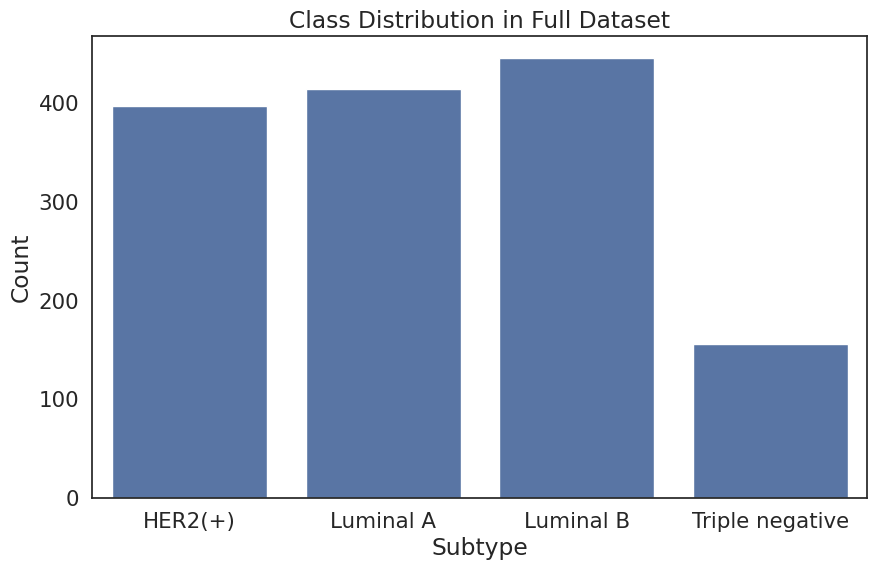

Class counts:
label
Luminal B          445
Luminal A          414
HER2(+)            397
Triple negative    156
Name: count, dtype: int64


In [10]:
# Class Distribution Analysis
plt.figure(figsize=(10, 6))
sns.countplot(data=full_df, x='label', order=sorted(full_df['label'].unique()))
plt.title("Class Distribution in Full Dataset")
plt.xlabel("Subtype")
plt.ylabel("Count")
plt.show()

print("Class counts:")
print(full_df['label'].value_counts())

Analyzing image dimensions...


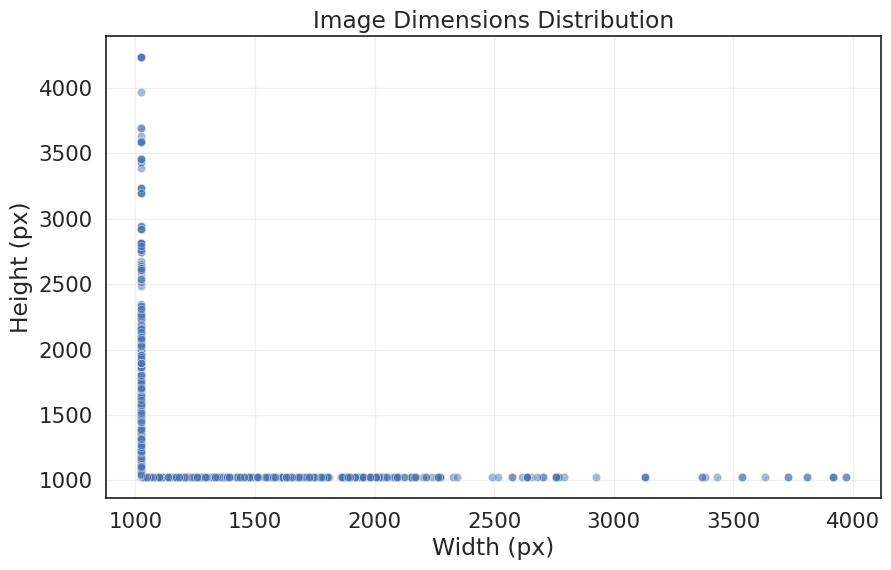

Dimension Statistics:
             Width       Height
count  1412.000000  1412.000000
mean   1252.313031  1341.359065
std     446.147652   509.641453
min    1024.000000  1024.000000
25%    1024.000000  1024.000000
50%    1024.000000  1097.500000
75%    1294.000000  1468.250000
max    3970.000000  4233.000000


In [11]:
# Image Dimension Analysis
sizes = []
# We'll check a subset to be fast, or all if small enough. 2366 is small enough.
print("Analyzing image dimensions...")
for idx, row in full_df.iterrows():
    img_path = os.path.join(train_set_dir, row['sample_index'])
    try:
        with Image.open(img_path) as img:
            sizes.append(img.size)
    except Exception as e:
        print(f"Error reading {img_path}: {e}")

sizes_df = pd.DataFrame(sizes, columns=['Width', 'Height'])

plt.figure(figsize=(10, 6))
sns.scatterplot(data=sizes_df, x='Width', y='Height', alpha=0.5)
plt.title("Image Dimensions Distribution")
plt.xlabel("Width (px)")
plt.ylabel("Height (px)")
plt.grid(True, alpha=0.3)
plt.show()

print("Dimension Statistics:")
print(sizes_df.describe())

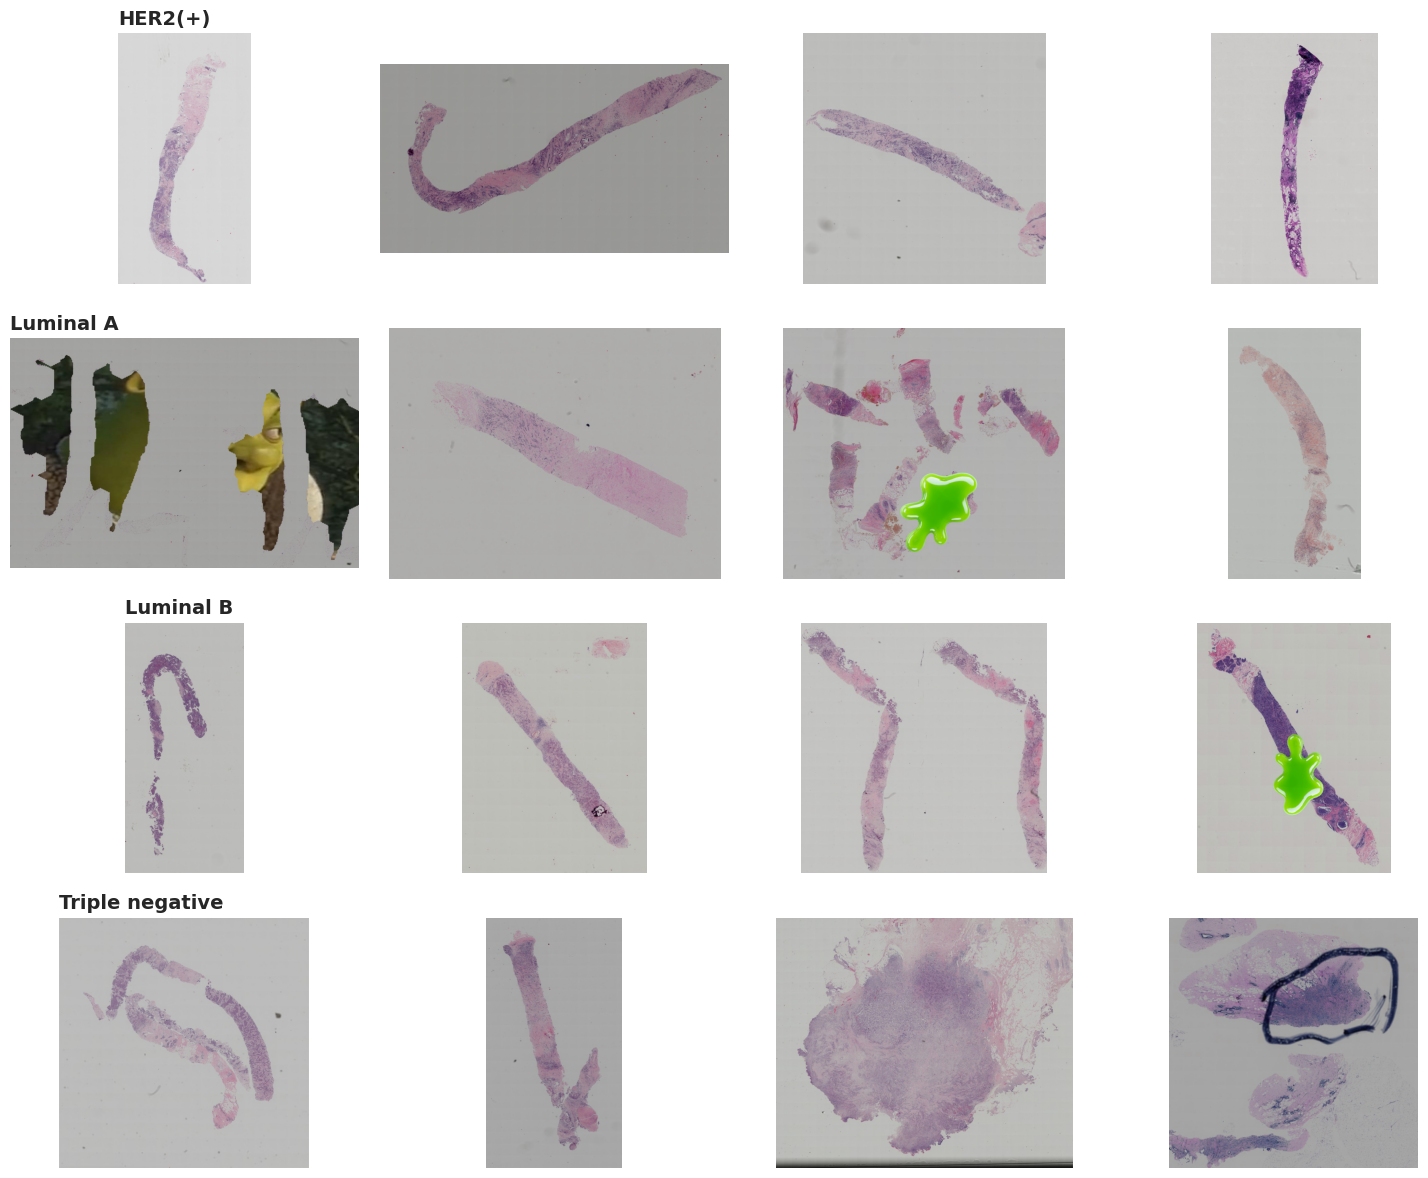

In [12]:
# Visualizing Samples per Class
def visualize_samples(df, num_samples=4):
    classes = sorted(df['label'].unique())
    fig, axes = plt.subplots(len(classes), num_samples, figsize=(15, 3*len(classes)))
    
    for i, cls in enumerate(classes):
        cls_samples = df[df['label'] == cls].sample(num_samples, random_state=SEED)
        for j, (_, row) in enumerate(cls_samples.iterrows()):
            img_path = os.path.join(train_set_dir, row['sample_index'])
            try:
                img = Image.open(img_path)
                axes[i, j].imshow(img)
                axes[i, j].axis('off')
                if j == 0:
                    axes[i, j].set_title(cls, fontsize=14, fontweight='bold', loc='left')
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
                
    plt.tight_layout()
    plt.show()

visualize_samples(full_df)

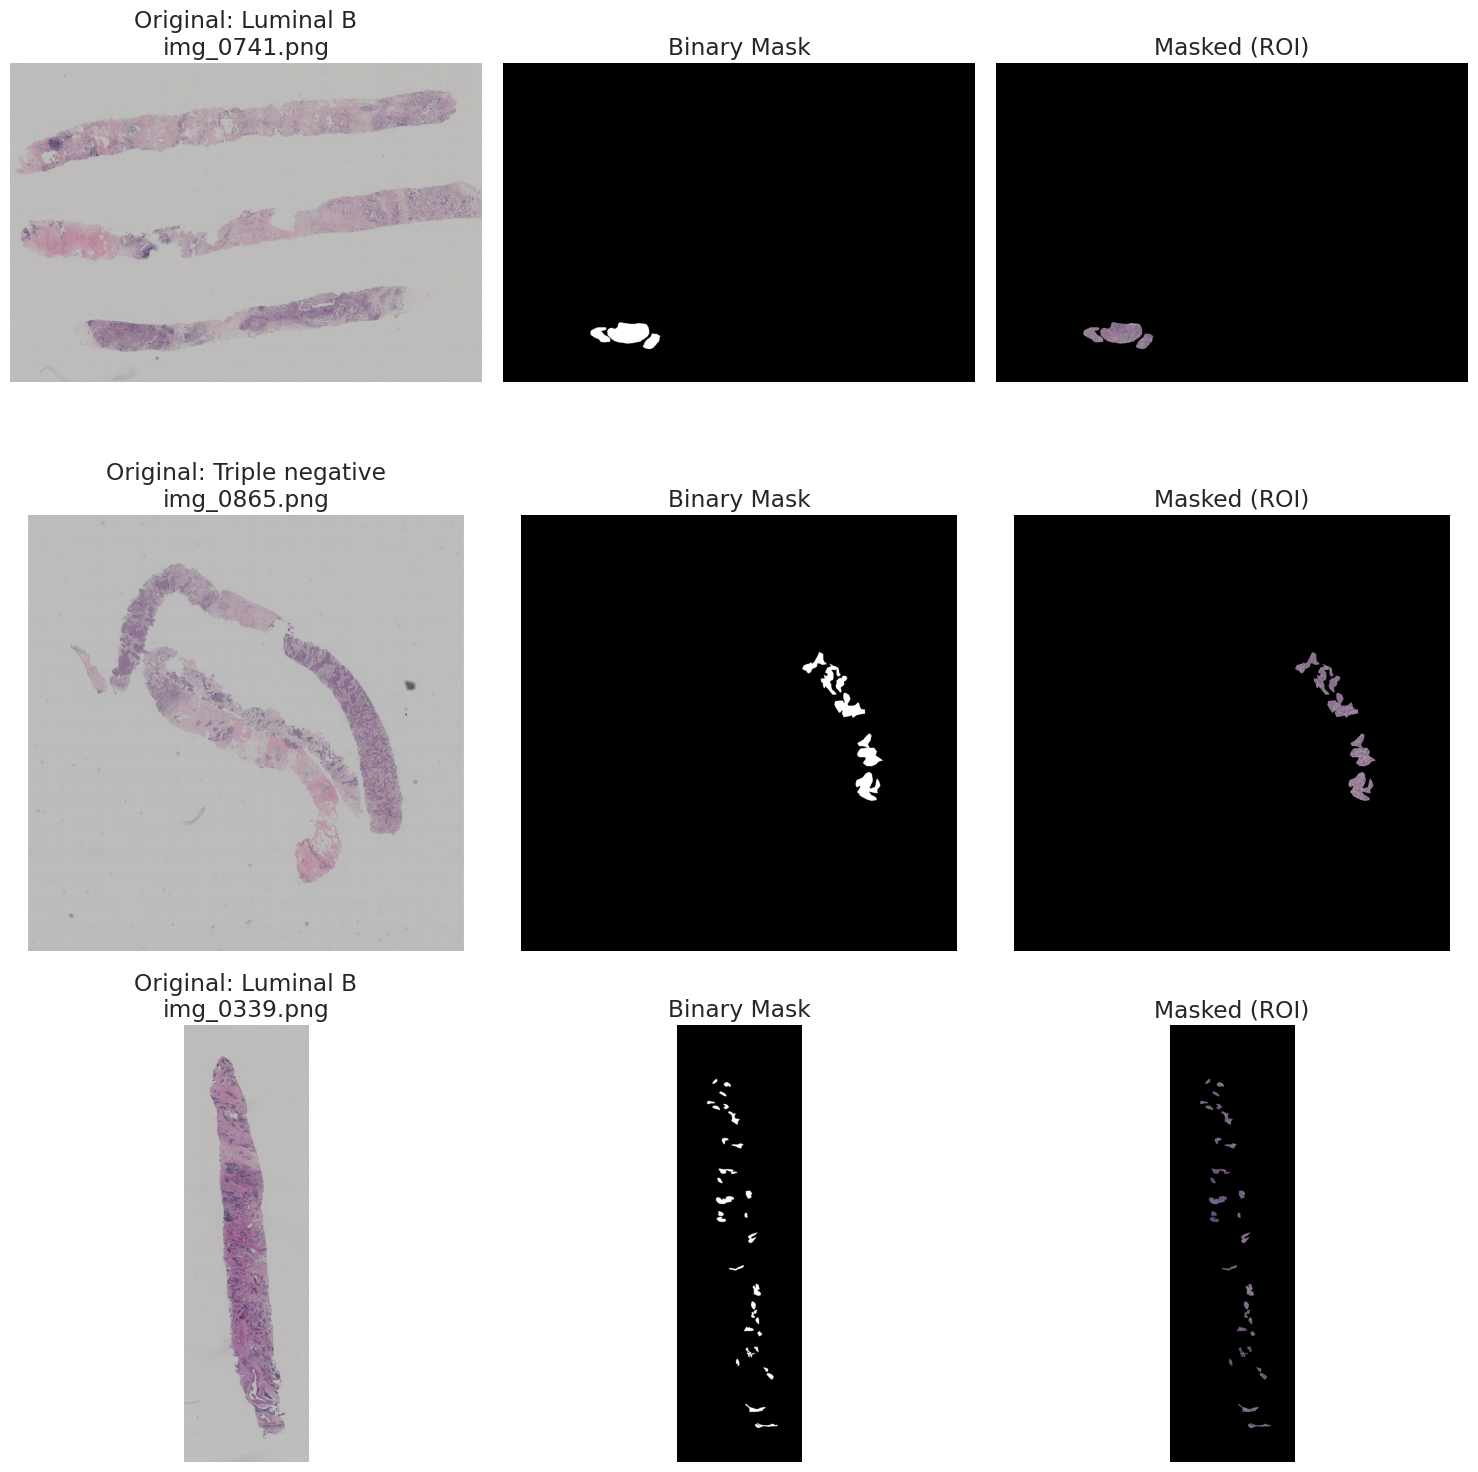

In [13]:
# Mask Analysis: ROI Visualization
def visualize_masks(df, num_samples=3):
    samples = df.sample(num_samples, random_state=SEED)
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    
    for i, (_, row) in enumerate(samples.iterrows()):
        img_id = row['sample_index']
        mask_id = img_id.replace('img_', 'mask_')
        
        img_path = os.path.join(train_set_dir, img_id)
        mask_path = os.path.join(train_set_dir, mask_id)
        
        try:
            img = Image.open(img_path).convert("RGB")
            mask = Image.open(mask_path).convert("L")
            
            # Apply mask
            img_np = np.array(img)
            mask_np = np.array(mask)
            binary_mask = (mask_np > 0).astype(np.uint8)
            masked_img = img_np * np.expand_dims(binary_mask, axis=-1)
            
            axes[i, 0].imshow(img)
            axes[i, 0].set_title(f"Original: {row['label']}\n{img_id}")
            axes[i, 0].axis('off')
            
            axes[i, 1].imshow(mask, cmap='gray')
            axes[i, 1].set_title("Binary Mask")
            axes[i, 1].axis('off')
            
            axes[i, 2].imshow(masked_img)
            axes[i, 2].set_title("Masked (ROI)")
            axes[i, 2].axis('off')
        except Exception as e:
            print(f"Error processing {img_id}: {e}")
            
    plt.tight_layout()
    plt.show()

visualize_masks(full_df)